# 데이터 준비

In [35]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [36]:
!cp /gdrive/MyDrive/temp/glaucoma.zip ./

In [37]:
!unzip glaucoma.zip

Archive:  glaucoma.zip
 extracting: test/advanced/371.png   
 extracting: test/advanced/372.png   
 extracting: test/advanced/373.png   
 extracting: test/advanced/374.png   
 extracting: test/advanced/375.png   
 extracting: test/advanced/376.png   
 extracting: test/advanced/377.png   
 extracting: test/advanced/378.png   
 extracting: test/advanced/379.png   
 extracting: test/advanced/380.png   
 extracting: test/advanced/381.png   
 extracting: test/advanced/382.png   
 extracting: test/advanced/383.png   
  inflating: test/advanced/384.png   
 extracting: test/advanced/385.png   
 extracting: test/advanced/386.png   
 extracting: test/advanced/387.png   
 extracting: test/advanced/388.png   
 extracting: test/advanced/389.png   
 extracting: test/advanced/390.png   
 extracting: test/advanced/391.png   
  inflating: test/advanced/392.png   
 extracting: test/advanced/393.png   
 extracting: test/advanced/394.png   
 extracting: test/advanced/395.png   
 extracting: test/advanced/

# 데이터 섞기

In [38]:
!rm -rf glaucoma
!rm -rf glaucoma.old
!rm -rf g

!unzip -q glaucoma.zip
!mkdir glaucoma.old
!mv train glaucoma.old/
!mv validation glaucoma.old/
!mv test glaucoma.old/

!mkdir -p g/normal
!mkdir -p g/early
!mkdir -p g/advanced

!cp glaucoma.old/train/normal/* g/normal/
!cp glaucoma.old/validation/normal/* g/normal/
!cp glaucoma.old/test/normal/* g/normal/
!cp glaucoma.old/train/early/* g/early/
!cp glaucoma.old/validation/early/* g/early/
!cp glaucoma.old/test/early/* g/early/
!cp glaucoma.old/train/advansed/* g/advanced/
!cp glaucoma.old/validation/advanced/* g/advanced/
!cp glaucoma.old/test/advanced/* g/advanced/

!mkdir -p glaucoma/train/normal
!mkdir -p glaucoma/train/early
!mkdir -p glaucoma/train/advanced
!mkdir -p glaucoma/test/normal
!mkdir -p glaucoma/test/early
!mkdir -p glaucoma/test/advanced
!mkdir -p glaucoma/validation//normal
!mkdir -p glaucoma/validation//early
!mkdir -p glaucoma/validation//advanced

replace test/advanced/371.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [39]:
import glob
import random
from shutil import copyfile, move

for category in ["normal", "early", "advanced"]:

  file_list = {}
  file_list = glob.glob("g/{}/*.png".format(category))
  random.shuffle(file_list)


  i1 = int(len(file_list)*0.8)
  i2 = int(len(file_list)*0.9)
  files = {
      'train':file_list[:i1],
      'validation':file_list[i1:i2],
      'test':file_list[i2:]
  }

  for data_type in ['train', 'validation', 'test']:
    target_dir = 'glaucoma/{}/{}/'.format(data_type, category)
    print("copy {} files to {}".format(len(files[data_type]), target_dir))
    for file_name in files[data_type]:
      move(file_name, target_dir)

copy 630 files to glaucoma/train/normal/
copy 79 files to glaucoma/validation/normal/
copy 79 files to glaucoma/test/normal/
copy 231 files to glaucoma/train/early/
copy 29 files to glaucoma/validation/early/
copy 29 files to glaucoma/test/early/
copy 373 files to glaucoma/train/advanced/
copy 47 files to glaucoma/validation/advanced/
copy 47 files to glaucoma/test/advanced/


# Vanilla CNN으로 학습

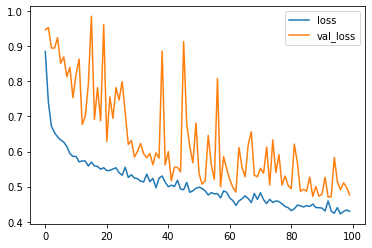

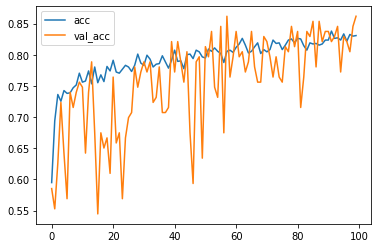

loss =  0.4297606647014618 , val_loss =  0.47645673155784607
18/18 [==============================] - 14s 770ms/step - loss: 0.4298 - acc: 0.8308 - val_loss: 0.4765 - val_acc: 0.8618


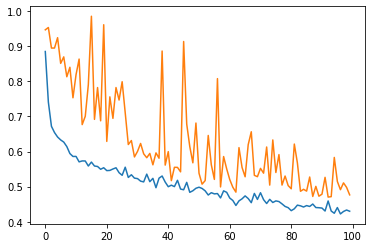

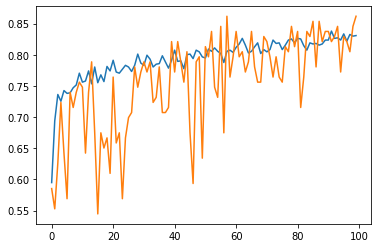

3/3 [==============================] - 1s 226ms/step - loss: 0.4973 - acc: 0.8000
loss= 0.49725931882858276
acc= 0.800000011920929


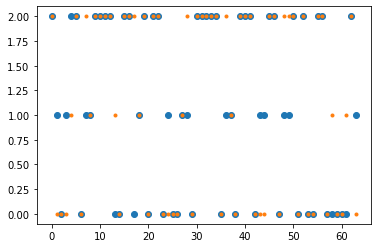

label category index = 2.0
predicted category index = 2
predicted category name = normal


In [40]:
# copy from https://gist.github.com/stared/dfb4dfaf6d9a8501cd1cc8b8cb806d2e

from IPython.display import clear_output
from tensorflow.keras.callbacks import Callback

class PlotLosses(Callback):

  def on_train_begin(self, logs={}):
    self.epochs = []
    self.losses = []
    self.val_losses = []
    self.acces = []
    self.val_acces = []
    self.logs = []
    self.fig = plt.figure()


  def on_epoch_end(self, epoch, logs={}):

    self.epochs.append(epoch)
    self.losses.append(logs.get('loss'))
    self.val_losses.append(logs.get('val_loss'))
    self.acces.append(logs.get('acc'))
    self.val_acces.append(logs.get('val_acc'))

    clear_output(wait=True)
    plt.plot(self.epochs, self.losses, label="loss")
    plt.plot(self.epochs, self.val_losses, label="val_loss")
    plt.legend()
    plt.show();

    plt.plot(self.epochs, self.acces, label="acc")
    plt.plot(self.epochs, self.val_acces, label="val_acc")
    plt.legend()
    plt.show();

    print("loss = ", self.losses[-1], ", val_loss = ", self.val_losses[-1])



import os

import matplotlib.pyplot as plt
import numpy as np

from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense, BatchNormalization, Conv2D, MaxPooling2D, Input
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

from tensorflow.keras.applications import efficientnet
from tensorflow.keras.applications import EfficientNetB2

preprocessor = efficientnet.preprocess_input

# conv_layers = EfficientNetB2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# conv_layers.trainable = True

model = keras.Sequential()

# model.add(conv_layers)
model.add(Input((224,224,3)))
model.add(Conv2D(32, (5,5), padding='same'))
model.add(Conv2D(32, (5,5), padding='same'))
model.add(Conv2D(32, (5,5), padding='same'))
model.add(MaxPooling2D())
model.add(Conv2D(32, (5,5), padding='same'))
model.add(Conv2D(32, (5,5), padding='same'))
model.add(Conv2D(32, (5,5), padding='same'))
model.add(MaxPooling2D())
model.add(Conv2D(64, (5,5), padding='same'))
model.add(Conv2D(64, (5,5), padding='same'))
model.add(Conv2D(64, (5,5), padding='same'))
model.add(MaxPooling2D())
model.add(Conv2D(64, (5,5), padding='same'))
model.add(Conv2D(64, (5,5), padding='same'))
model.add(Conv2D(64, (5,5), padding='same'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(3, activation='softmax'))

import tensorflow
optimizer = tensorflow.keras.optimizers.Adam(learning_rate=0.0001*0.1)
# model.compile(loss='sparse_categorical_crossentropy', optimizer="RMSprop", metrics=['acc'])
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['acc'])
model.summary()

BATCH_SIZE = 64

train_data_generator = ImageDataGenerator(
      rotation_range=10,
      width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True,
      vertical_flip=False,
      rescale=1/255.,
      validation_split=0.1
      # preprocessing_function=preprocessor
).flow_from_directory(
      "glaucoma/train",
      target_size=(224,224),
      batch_size=BATCH_SIZE,
      class_mode='sparse',
      subset="training"
)


valid_data_generator = ImageDataGenerator(
      rescale=1/255.,
      validation_split=0.1      
      # preprocessing_function=preprocessor
).flow_from_directory(
      "glaucoma/train",
      target_size=(224,224),
      batch_size=BATCH_SIZE,
      class_mode='sparse',
      subset="validation"
)

test_data_generator = ImageDataGenerator(
      rescale=1/255.,
      # preprocessing_function=preprocessor
).flow_from_directory(
      "glaucoma/test",
      target_size=(224,224),
      batch_size=BATCH_SIZE,
      class_mode='sparse'
)


plot_losses = PlotLosses()
history = model.fit(
      train_data_generator,
      validation_data=valid_data_generator,
      epochs=100,
      callbacks=[plot_losses]
)


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.show()

loss, acc = model.evaluate(test_data_generator)
print("loss=", loss)
print("acc=", acc)



batch_x, batch_y = test_data_generator.next()
y_ = model.predict(batch_x)
predicted = np.argmax(y_, axis=-1)

plt.plot(batch_y[:100], "o")
plt.plot(predicted[:100], '.')
plt.show()


custom_labels = list(test_data_generator.class_indices.keys())
print("label category index =", batch_y[0])
print("predicted category index =", predicted[0])
print("predicted category name =", custom_labels[predicted[0]])


# GradCAM

In [41]:
!pip install --upgrade tf-keras-vis matplotlib

  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [42]:
batch_x, batch_y = next(iter(test_data_generator))
images = batch_x
labels = batch_y.astype(np.int)

In [47]:
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf


from tensorflow.keras import backend as K
from tf_keras_vis.utils import normalize
from matplotlib import cm

In [48]:
def draw_gradcam(model, images, labels, preprocess):
    
    X = preprocess(images)

    def loss(output):
        return [ output[i][labels[i]] for i in range(len(labels)) ]

    def model_modifier(m):
        m.layers[-1].activation = tf.keras.activations.linear
        return m

    from tf_keras_vis.gradcam import GradcamPlusPlus

    gradcam = GradcamPlusPlus(model, model_modifier, clone=False)

    TARGET_LAYER_NUMBER = -1 # 마지막 층
    # Generate heatmap with GradCAM++
    cam = gradcam(loss, X, penultimate_layer=TARGET_LAYER_NUMBER)

    for i in range(len(images)):
        heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
        plt.imshow(images[i])
        plt.imshow(heatmap, cmap='jet', alpha=0.5)
        plt.show()
            

In [ ]:
images, labels = next(iter(test_data_generator))

labels = labels.astype(np.int)

def preprocess(img):
    return img

draw_gradcam(model, images, labels, preprocess)

In [52]:
def draw_fast_score_gradcam(model, images, labels, preprocess):

    X = preprocess(images)

    def loss(output):
        return [ output[i][labels[i]] for i in range(len(labels)) ]

    def model_modifier(m):
        m.layers[-1].activation = tf.keras.activations.linear
        return m    

    from tf_keras_vis.scorecam import ScoreCAM

    scorecam = ScoreCAM(model, model_modifier, clone=False)

    TARGET_LAYER_NUMBER = -1 # 마지막 층
    cam = scorecam(loss, X, penultimate_layer=TARGET_LAYER_NUMBER, max_N=10)

    cam = normalize(cam)

    for i in range(len(images)):
        heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
        plt.imshow(images[i])
        plt.imshow(heatmap, cmap='jet', alpha=0.5)
        plt.show()   

In [ ]:
def preprocess(img):
    return img
    
draw_fast_score_gradcam(model, images, labels, preprocess)